In [1]:
from __future__ import print_function, division
import argparse
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import os, shutil
import math
import fnmatch
import nets
import utils
from collections import OrderedDict
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import time
import copy
import seaborn as sns
from pytorch_model_summary import summary
# from .collection import imread_collection_wrapper

# print("PyTorch Version: ",torch.__version__)
# print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 3080 Ti


In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
#     print(output.size())
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def save_checkpoint(state, is_best_loss, filename='checkpoint.pth.tar', dirname='.'):
    fpath = os.path.join(dirname, filename + '_latest.pth.tar')
    torch.save(state, fpath)
    if is_best_loss:
        bpath = os.path.join(dirname, filename + '_best_loss.pth.tar')
        shutil.copyfile(fpath, bpath)
        
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          my_dpi=100,
                          title=None,
                          saved=True,
                          save_name='DeepLearning.png'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 1),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize, dpi=my_dpi)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if saved:
        plt.savefig(save_name, dpi=my_dpi*10, bbox_inches='tight')

In [3]:
class CAE_3D_bn(nn.Module):
    def __init__(self, input_shape=[80,80,80,1], latent_channels=512, filters=[16, 32, 64, 128]):
        super(CAE_3D_bn, self).__init__()
        self.pretrained = False
        self.latent_channels = latent_channels
        self.input_shape = input_shape
        self.filters = filters
        
        self.encoder3d = nn.Sequential(OrderedDict([
            ('conv3d1_1', weight_norm(nn.Conv3d(input_shape[3], filters[0], 3, padding=1))),
          ('relu3d1_1', nn.ReLU()),
          ('maxpool3d1_1', nn.MaxPool3d(2)),
          ('bn3d1_1', nn.BatchNorm3d(filters[0])),
            ('conv3d2_1', weight_norm(nn.Conv3d(filters[0], filters[1], 3, padding=1))),
          ('relu3d2_1', nn.ReLU()),
          ('maxpool3d2_1', nn.MaxPool3d(2)),
          ('bn3d2_1', nn.BatchNorm3d(filters[1])),
            ('conv3d3_1', weight_norm(nn.Conv3d(filters[1], filters[2], 3, padding=1))),
          ('relu3d3_1', nn.ReLU()),
          ('maxpool3d3_1', nn.MaxPool3d(2)),
          ('bn3d3_1', nn.BatchNorm3d(filters[2])),
            ('conv3d4_1', weight_norm(nn.Conv3d(filters[2], filters[3], 3, padding=1))),
          ('relu3d4_1', nn.ReLU()),
          ('maxpool3d4_1', nn.MaxPool3d(2))
        ]))
        lin_features_len_3d = (filters[3])*(input_shape[0]//2//2//2//2)*(input_shape[1]//2//2//2//2)*(input_shape[2]//2//2//2//2)
        self.embedding3d = nn.Linear(lin_features_len_3d, latent_channels)
        self.deembedding3d = nn.Linear(latent_channels, lin_features_len_3d)
        self.relu = nn.ReLU()
        self.bn_fc1 = nn.BatchNorm1d(latent_channels)
        
        self.decoder3d = nn.Sequential(OrderedDict([
            ('upsample3d1_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('upsample3d2_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d1_2', weight_norm(nn.Conv3d(filters[3], filters[2], 3, padding=1))),
          ('relu3d1_2', nn.ReLU()),
          ('bn3d1_2', nn.BatchNorm3d(filters[2])),
            ('upsample3d3_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d2_2', weight_norm(nn.Conv3d(filters[2], filters[1], 3, padding=1))),
          ('relu3d2_2', nn.ReLU()),
          ('bn3d2_2', nn.BatchNorm3d(filters[1])),
            ('upsample3d4_2', nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)),
            ('conv3d3_2', weight_norm(nn.Conv3d(filters[1], filters[0], 3, padding=1))),
          ('relu3d3_2', nn.ReLU()),
          ('bn3d3_2', nn.BatchNorm3d(filters[0])),
            ('conv3d4_2', nn.Conv3d(filters[0], input_shape[3], 1)),
          ('relu3d4_2', nn.ReLU())
        ]))
        

    def forward(self, x):
        # SSC
        x = self.encoder3d(x)
        x = x.view(x.size(0),-1)
        x = self.embedding3d(x)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x_out = x
        
        x = self.deembedding3d(x)
        x = x.view(x.size(0), self.filters[3], self.input_shape[0]//2//2//2//2, self.input_shape[1]//2//2//2//2, self.input_shape[2]//2//2//2//2) # 128 5^3
        
        x = self.decoder3d(x)
        
        return x, x_out 

In [4]:
print(summary(CAE_3D_bn(latent_channels=256),torch.zeros((1,1,80,80,80)), show_input=False))

----------------------------------------------------------------------------
      Layer (type)             Output Shape         Param #     Tr. Param #
          Conv3d-1      [1, 16, 80, 80, 80]             464             464
            ReLU-2      [1, 16, 80, 80, 80]               0               0
       MaxPool3d-3      [1, 16, 40, 40, 40]               0               0
     BatchNorm3d-4      [1, 16, 40, 40, 40]              32              32
          Conv3d-5      [1, 32, 40, 40, 40]          13,888          13,888
            ReLU-6      [1, 32, 40, 40, 40]               0               0
       MaxPool3d-7      [1, 32, 20, 20, 20]               0               0
     BatchNorm3d-8      [1, 32, 20, 20, 20]              64              64
          Conv3d-9      [1, 64, 20, 20, 20]          55,424          55,424
           ReLU-10      [1, 64, 20, 20, 20]               0               0
      MaxPool3d-11      [1, 64, 10, 10, 10]               0               0
    BatchNo

In [5]:
def pretraining(model, dataloaders, criterion, optimizers, schedulers, params):
    # Note the time
    since = time.time()
    
    best_val_loss = np.inf
    losses_tr = []
    losses_val = []
    learning_rate = []

    # Unpack parameters
    pretrained = params['model_files'][1]
    print_freq = params['print_freq']
    device = params['device']
    batch = params['batch']
    num_epochs = params['pretrain_epochs']
    

    # Prep variables for weights and accuracy of the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # optionally resume from a checkpoint
    if params['resume']:
        if os.path.isfile(params['resume']):
            print("=> loading checkpoint '{}'".format(params['resume']))
            checkpoint = torch.load(params['resume'])
            args.start_epoch = checkpoint['epoch']

            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(params['resume']))
            
    ckpt_dir = params['ckpt_dir']
    
    optimizer1, optimizer2 = optimizers
    scheduler1, scheduler2 = schedulers
    dataloader_train, dataloader_val = dataloaders
    
    # Go through all epochs
    print('\n\nPretraining\n\n')
    for epoch in range(num_epochs):
        print('\n\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        if epoch < 5:
            for param_group in optimizer1.param_groups:
                print("\nLR:", param_group['lr'], '\n---------------------')
                lr = param_group['lr']
        else:
            for param_group in optimizer2.param_groups:
                print("\nLR:", param_group['lr'], '\n---------------------')
                lr = param_group['lr']
                
        loss_tr = pretrain_train(dataloader_train, model, criterion, optimizers, params, epoch)
        loss_val = pretrain_validate(dataloader_val, model, criterion, params, epoch)
        
        # learning scheduler
        if epoch < 5:
            scheduler1.step(loss_val)
        elif epoch > num_epochs * (1/3):
            scheduler2.step(loss_val)
            
        # append values
        losses_tr.append(loss_tr)
        losses_val.append(loss_val)
        learning_rate.append(lr)
        
        is_best_loss = loss_val < best_val_loss
        if is_best_loss:
            best_val_loss = min(loss_val, best_val_loss)
            print('Best loss reached at epoch: {:.0f}\t Accuracy: {:.3f}'.format(epoch, best_val_loss))
            best_model_wts = copy.deepcopy(model.state_dict())

        
            
        dict_checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'losses_tr': losses_tr,
            'losses_val': losses_val,
            'learning_rate' : learning_rate,
        }
        
        save_checkpoint(dict_checkpoint, is_best_loss, 'Pretrain_'+str(params['boundary']), dirname=ckpt_dir)

    time_elapsed = time.time() - since
    print('Pretraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    model.pretrained = True
    torch.save(model.state_dict(), pretrained)

    return model

def pretrain_train(dataloader, model, criterion, optimizers, params, epoch, k=2):
    # Note the time
    since = time.time()
    
    losses = AverageMeter()
    
    device = params['device']
    print_freq = params['print_freq']
    optimizer1, optimizer2 = optimizers
    
    model.train()
    print('\nTraining:')
    data_iter = iter(dataloader) 
    for i in range(len(data_iter)):
        inputs, labels= next(data_iter)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # compute outputs
        outputs, _ = model(inputs)
        
        loss = criterion(outputs*65535, inputs*65535)
        losses.update(loss.item(), inputs.size(0))
        
        # compute gradient and do SGD step
        if epoch < 5:
            optimizer1.zero_grad()
        else:
            optimizer2.zero_grad()
        
        loss.backward()
        
        if epoch < 5:
            optimizer1.step()
        else:
            optimizer2.step()
            
        if (i+1) % print_freq == 0:
            print('Train: Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch+1, i+1, len(data_iter), loss=losses))
    print('Loss {loss.avg:.4f}, \t Time: {time}'.format(loss=losses, time=time.time()-since))
    return losses.avg

def pretrain_validate(dataloader, model, criterion, params, epoch, mode='valid', k=2):
    # Note the time
    since = time.time()
    
    losses = AverageMeter()
    
    device = params['device']
    print_freq = params['print_freq']
    
    model.eval()
    print('\n')
    print(mode,':')
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # compute outputs
            outputs, _ = model(inputs)

            loss = criterion(outputs*65535, inputs*65535)
            losses.update(loss.item(), inputs.size(0))

            if (i+1) % print_freq == 0:
                print('Validation: Epoch: [{0}][{1}/{2}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                       epoch+1, i+1, len(dataloader), loss=losses))
                
    print('Loss {loss.avg:.4f}, \t Time: {time}'.format(loss=losses, time=time.time()-since))
    return losses.avg


In [6]:
import os

from skimage import io
import skimage.transform
import scipy
import scipy.io as sio
from torch.utils.data.dataset import Dataset

class MyDataset_mat(Dataset):
    def __init__(self, mat_paths, labels, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        data = sio.loadmat(self.paths[index])['data']
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = x.unsqueeze(dim = 0)
        label = torch.from_numpy(np.asarray(self.labels[index]))
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [7]:
# important parameters
mode = 'pretrain' # 'pretrain'
pretrain = True # pretrain the model or not
pretrained_net = 1 # if loading the pretrained network, the index of the pretrained networks

rate_pretrain = 1e-5 # pretraining learning rate
rate_pretrain_init = 1e-5
pretrain_epochs = 150 # training epoches
latent_channels = 256 # Number of latent channels

# Other parameters
net_architecture = 'CAE_3D_bn'
weight = 0.5 # Adam params clustering weight decay
weight_pretrain = 0.5 # Adam params pretraining weight decay
dataset = '3D-IFC'
patience_step = 5 # clustering Scheduler patience steps for rate update
patience_step_pretrain = 5 # training Scheduler patience steps for rate update
print_freq = 100 # training stats printing frequency

if mode == 'pretrain' and not pretrain:
    print("Nothing to do :(")
    raise('Error: mode set to pretrain but pretrain disabled')

# parameters in dictionary
params = {}
params['resume'] = ''
params['pretrain'] = pretrain
params['net_arch'] = net_architecture
# Epochs
params['pretrain_epochs'] = pretrain_epochs
# Printing frequency
params['print_freq'] = print_freq

params['ckpt_dir'] = ''

net_is_path = True
if not pretrain:
    try:
        int(pretrained_net)
        idx = pretrained_net
        net_is_path = False
    except:
        pass
dirs = ['runs', 'reports', 'nets']
list(map(lambda x: os.makedirs(x, exist_ok=True), dirs))

# Net architecture
model_name = net_architecture
# Indexing (for automated reports saving) - allows to run many trainings and get all the reports collected
if pretrain or (not pretrain and net_is_path):
    reports_list = sorted(os.listdir('nets'), reverse=True)
    if reports_list:
        for file in reports_list:
            # print(file)
            if fnmatch.fnmatch(file, model_name + '*' + 'pretrained.pt'):
                idx = int(str(file)[-17:-14]) + 1
                break
    try:
        idx
    except NameError:
        idx = 1
print(idx)
# Base filename
name = model_name + '_' + str(idx).zfill(3)
params['boundary'] = str(idx).zfill(3)

# Filenames for report and weights
# name_txt = name + '.txt'
name_net = name
pretrained = name + '_pretrained.pt'

# Arrange filenames for report, network weights, pretrained network weights
# name_txt = os.path.join('reports', name_txt)
name_net = os.path.join('nets', name_net)
name_pretrained = os.path.join('nets', pretrained)

if net_is_path and not pretrain:
    pretrained = pretrained_net
else:
    pretrained = os.path.join('nets', pretrained)
if not pretrain and not os.path.isfile(pretrained):
    print("No pretrained weights, try again choosing pretrained network or create new with pretrain=True")

model_files = [name_net, pretrained]
params['model_files'] = model_files
params['ckpt'] = os.path.join('nets', 'ckpt')


1


In [8]:
import pandas as pd
datadir = 'E:/Research/Dataset_v4/3DImagesKFold-aug-mat'
train_file = 'train_filelist.csv'
val_file = 'val_filelist.csv'

train_data = pd.read_csv(os.path.join(datadir, train_file))
trainname = train_data.name
trainlabel = train_data.label

trainpath = []
for filename in trainname:
    trainpath.append(datadir+filename)
    
val_data = pd.read_csv(os.path.join(datadir, val_file))
valname = val_data.name
vallabel = val_data.label

valpath = []
for filename in valname:
    valpath.append(datadir+filename)
    
print(trainpath[0])
print(valpath[0])

train_datasets = MyDataset_mat(trainpath, trainlabel)
val_datasets = MyDataset_mat(valpath, vallabel)

print('Training data size: ', len(train_datasets))
print('Validation data size: ', len(val_datasets))

E:/Research/Dataset_v4/3DImagesKFold-aug-mat/Gra_Y/Fold-2/00056-001-2-2_Ch2.mat
E:/Research/Dataset_v4/3DImagesKFold-aug-mat/Gra_Y/Fold-1/00005-002-2-2_Ch2.mat
Training data size:  29763
Validation data size:  8205


In [9]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# dataloaders
dataloader_train = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
dataloaders = [dataloader_train, dataloader_val]

dataset_size = {'train': len(train_datasets), 'val': len(val_datasets)}
params['dataset_size'] = dataset_size

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params['device'] = device
params['batch'] = batch_size

Initializing Datasets and Dataloaders...


In [ ]:
ckpt_dir = params['ckpt'] + '_' + params['net_arch'] + '_' + params['boundary']
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
print(ckpt_dir)
params['ckpt_dir'] = ckpt_dir

# Evaluate the proper model
img_size = [80,80,80,1]
to_eval = model_name + "(img_size, latent_channels=latent_channels)"
model = eval(to_eval)

model = model.to(device)
# Reconstruction loss
criterion_1 = nn.MSELoss(reduction='mean')

# optimizer_pretrain = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain, weight_decay=weight_pretrain)
optimizer_ft1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain_init,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
optimizer_ft2 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=patience_step_pretrain, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=patience_step_pretrain, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       


optimizers = [optimizer_ft1, optimizer_ft2]
schedulers = [exp_lr_scheduler1, exp_lr_scheduler2]

model = pretraining(model, dataloaders, criterion_1, optimizers, schedulers, params)

# Save final model
torch.save(model.state_dict(), name_pretrained)

nets\ckpt_CAE_3D_bn_001


Pretraining




Epoch 1/150
----------

LR: 1e-05 
---------------------

Training:


In [10]:
fpath = 'nets/ckpt_CAE_3D_bn_002/Pretrain_002_best_loss.pth.tar'
scratch_model = torch.load(fpath)
print(scratch_model.keys())

dict_keys(['epoch', 'state_dict', 'losses_tr', 'losses_val', 'learning_rate'])


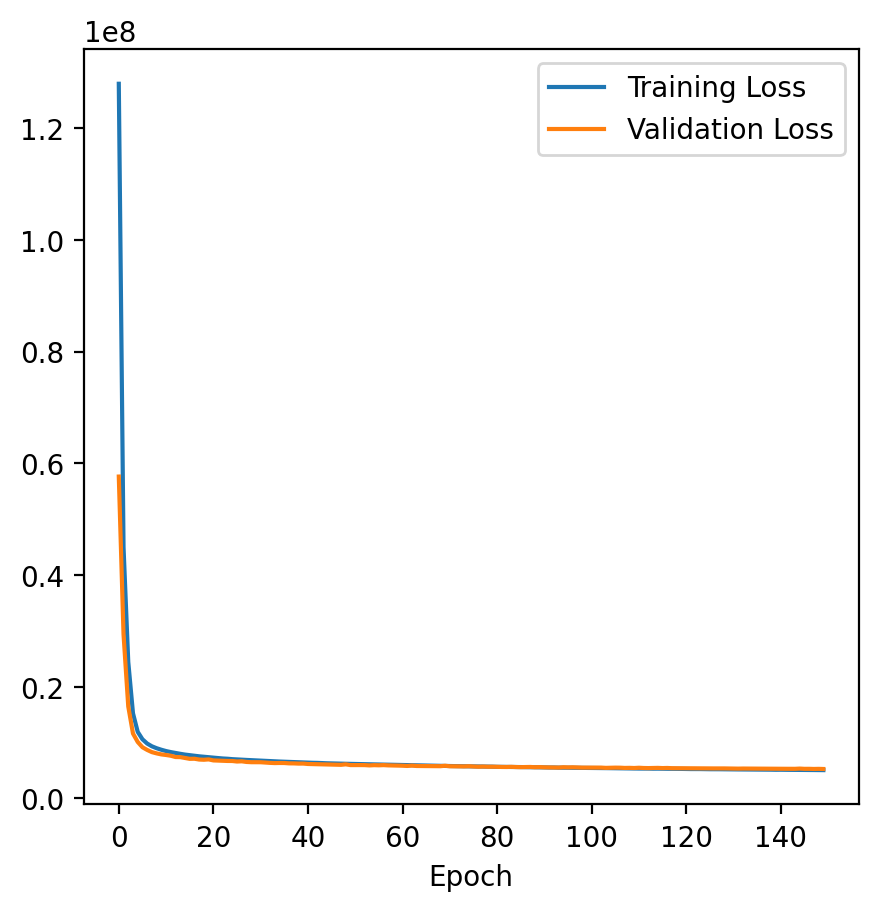

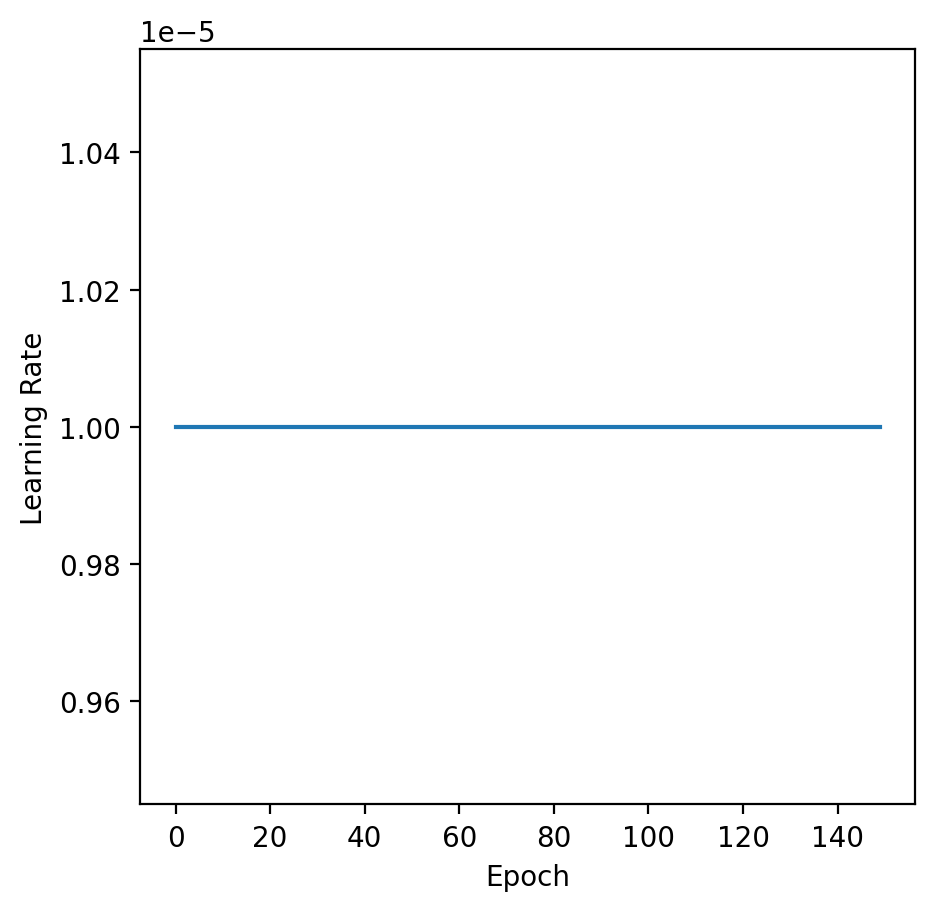

In [11]:
from matplotlib import pyplot as plt
my_dpi = 200
plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.plot(range(0,scratch_model['epoch']), scratch_model['losses_tr'],label='Training Loss')
plt.plot(range(0,scratch_model['epoch']), scratch_model['losses_val'],label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
# plt.savefig('nets/ckpt_CAE_3D_bn_002/Fig_save/Unsupervised learning - Loss.png', dpi=200 * 10)
plt.show()


plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.plot(range(0,scratch_model['epoch']), scratch_model['learning_rate'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
# plt.savefig('nets/ckpt_CAE_3D_bn_002/Fig_save/Unsupervised learning - LR.png', dpi=200 * 10)
plt.show()

In [12]:
img_size = [80, 80, 80, 1]
num_clusters = 3
latent_channels = 256
model_name = 'CAE_3D_bn'
to_eval = model_name + "(img_size, latent_channels=latent_channels)"
model = eval(to_eval)
model.to(device)
model.load_state_dict(scratch_model['state_dict'])
model.eval()
print(model)

CAE_3D_bn(
  (encoder3d): Sequential(
    (conv3d1_1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu3d1_1): ReLU()
    (maxpool3d1_1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3d1_1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3d2_1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu3d2_1): ReLU()
    (maxpool3d2_1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3d2_1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3d3_1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu3d3_1): ReLU()
    (maxpool3d3_1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3d3_1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3d4_1): Conv3d(64, 128, kernel_size=

In [13]:
from skimage import io
import skimage.transform
import scipy
import scipy.io as sio
from torch.utils.data.dataset import Dataset

class MyDataset_mat_idx(Dataset):
    def __init__(self, mat_paths, labels, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        data = sio.loadmat(self.paths[index])['data']
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = x.unsqueeze(dim = 0)
        
        label = torch.from_numpy(np.asarray(self.labels[index]))

        if self.transforms:
            x= self.transforms(x)
        return x,label,index
    
    def __len__(self):
        return len(self.paths)

In [14]:
import pandas as pd

csv_path = './reports/WBC+Leu_GroundTruthLabel&ClusterLabel.csv'

csv_data = pd.read_csv(csv_path)

sscpath = csv_data.name
cluster_label = csv_data.cluster
truth_label = csv_data.label

wbcpath, wbc_label = [], []
train = list(range(0,len(sscpath)))
for i in train:
    wbcpath.append(sscpath[i])
    wbc_label.append(truth_label[i])

wbc_datasets = MyDataset_mat_idx(wbcpath, wbc_label)

batch_size = 64

dataloader_wbcleu = torch.utils.data.DataLoader(wbc_datasets, batch_size=batch_size, shuffle=True, num_workers=0)

print('Dataset Size:', len(wbc_datasets))

Dataset Size: 10008


In [15]:
model.to(device)
model.eval()
with torch.no_grad():
    for i, data in enumerate(dataloader_wbcleu):
        inputs, label, index = data
        inputs = inputs.to(device)
        outputs, extra_out = model(inputs)
        extra_out = extra_out.cpu().clone().numpy()
        if i == 0:
            labellist_mix = label
            latent_out_mix = extra_out
            index_mix = index
        else:
            latent_out_mix = np.append(latent_out_mix, extra_out, axis=0)
            labellist_mix = np.append(labellist_mix, label, axis=0)
            index_mix = np.append(index_mix, index, axis=0)
        
print('Label shape:', labellist_mix.shape)
print('Latent Space shape:', latent_out_mix.shape)

Label shape: (10008,)
Latent Space shape: (10008, 256)


In [16]:
from openTSNE import TSNE
# from sklearn.manifold import TSNE
# import seaborn as sns
tsne = TSNE(n_components=2, random_state=5, verbose=1, perplexity=200, learning_rate=5e3, early_exaggeration=40, n_iter=5000)
X_2d_mix = tsne.fit(latent_out_mix)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=40, learning_rate=5000.0, n_iter=5000, perplexity=200,
     random_state=5, verbose=1)
--------------------------------------------------------------------------------
===> Finding 600 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 11.50 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.42 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=40.00, lr=5000.00 for 250 iterations...
Iteration   50, KL divergence 4.1296, 50 iterations in 3.1304 sec
Iteration  100, KL divergence 3.9316, 50 iterations in 3.1286 sec
Iteration  150, KL divergence 3.9366, 50 iterations in 3.1952 sec
Iteration  200, KL divergence 3.9084, 50 iterations in 3.1212 sec
Iteration  250, KL divergence 3.9193, 50 iterations in 3.0779 sec
   --> Time elapsed: 15.65 seconds


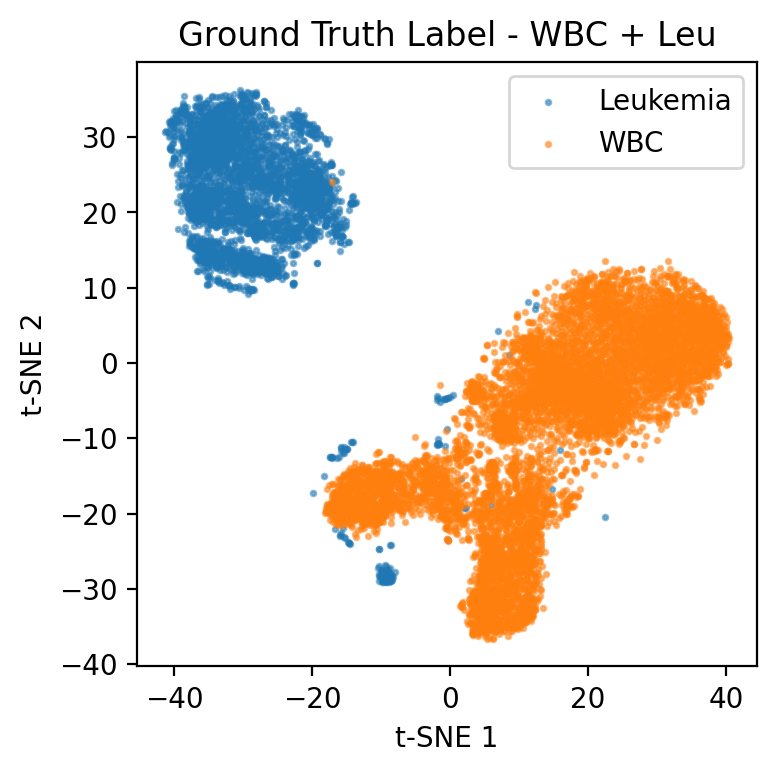

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4), dpi = 200)
plt.scatter(X_2d_mix[labellist_mix==0, 0], X_2d_mix[labellist_mix==0, 1], s=3, alpha=0.5)
plt.scatter(X_2d_mix[labellist_mix==1, 0], X_2d_mix[labellist_mix==1, 1], s=3, alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Ground Truth Label - WBC + Leu')
plt.legend(['Leukemia', 'WBC'])
# plt.savefig('nets/ckpt_CAE_3D_bn_002/Fig_save/Ground Truth Visualization - WBC + Leu.png', dpi=200 * 10)
plt.show()

In [25]:
dataset = latent_out_mix
num_clusters = 2
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
## MiniBatchKMeans
mbkmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=1, batch_size=512)
## KMeans
# mbkmeans = KMeans(n_clusters=num_clusters, random_state=10)
mbkmeans = Birch(n_clusters=num_clusters)
# mbkmeans = AgglomerativeClustering(n_clusters=num_clusters)
# mbkmeans = GaussianMixture(n_components=num_clusters)
c_idx_mbk_mix = mbkmeans.fit_predict(dataset)

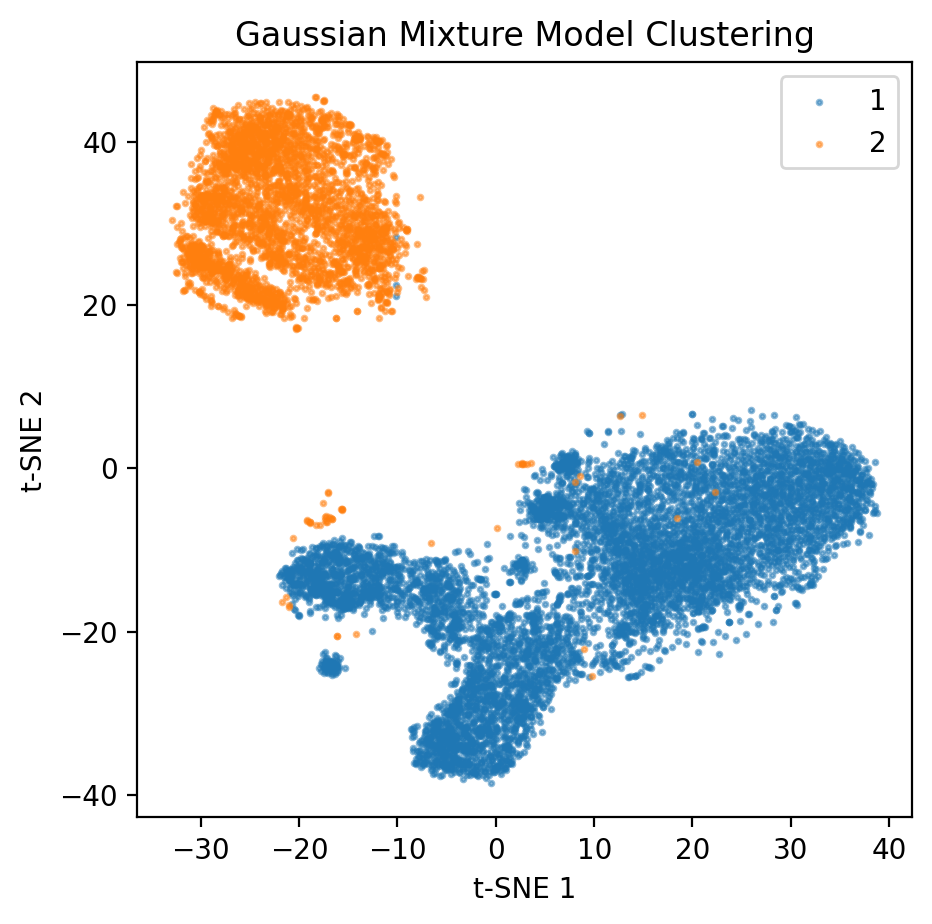

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,5), dpi=200)
plt.scatter(X_2d_mix[c_idx_mbk_mix==0, 0], X_2d_mix[c_idx_mbk_mix==0, 1], s=3, alpha=0.5)
plt.scatter(X_2d_mix[c_idx_mbk_mix==1, 0], X_2d_mix[c_idx_mbk_mix==1, 1], s=3, alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Gaussian Mixture Model Clustering')
plt.legend(['1','2'])
# plt.savefig('nets/ckpt_CAE_3D_bn_002/Fig_save/GMM Clustering Result - WBC + Leu.png', dpi=200 * 10)
plt.show()

In [27]:
idx_match_mix = [0]*len(c_idx_mbk_mix)
for i,idx in enumerate(c_idx_mbk_mix):
    if idx == 0:
        idx_match_mix[i] = 1
    else:
        idx_match_mix[i] = 0
idx_match_mix = np.array(idx_match_mix)
print(idx_match_mix[:20])
print(labellist_mix[:20])

[1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0]
[1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0]


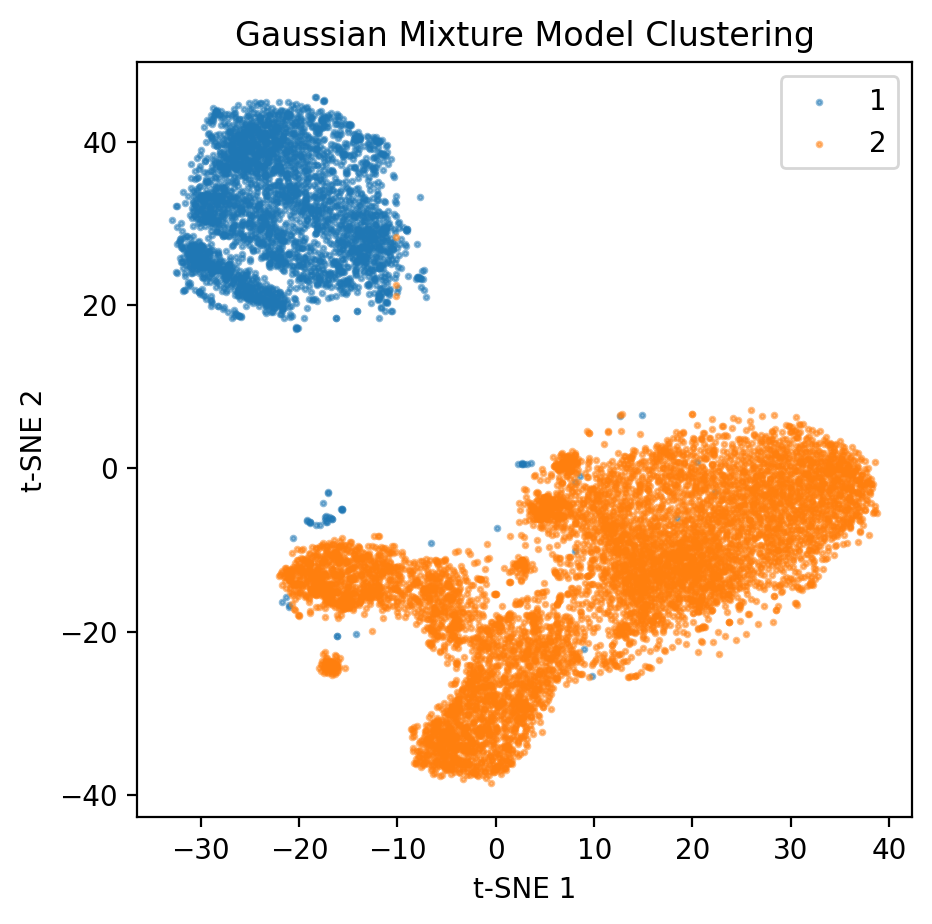

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,5), dpi=200)
plt.scatter(X_2d_mix[idx_match_mix==0, 0], X_2d_mix[idx_match_mix==0, 1], s=3, alpha=0.5)
plt.scatter(X_2d_mix[idx_match_mix==1, 0], X_2d_mix[idx_match_mix==1, 1], s=3, alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Gaussian Mixture Model Clustering')
plt.legend(['1','2'])
# plt.savefig('nets/ckpt_CAE_3D_bn_002/Fig_save/GMM Clustering Result - WBC + Leu - matched.png', dpi=200 * 10)
plt.show()

In [29]:
cm = confusion_matrix(labellist_mix, idx_match_mix, labels = [0,1])
cr = classification_report(labellist_mix, idx_match_mix, labels = [0,1])
bas = balanced_accuracy_score(labellist_mix, idx_match_mix)
print(cm)
print(cr)
print(bas)

[[3037  148]
 [   7 6816]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      3185
           1       0.98      1.00      0.99      6823

    accuracy                           0.98     10008
   macro avg       0.99      0.98      0.98     10008
weighted avg       0.98      0.98      0.98     10008

0.9762531202178613


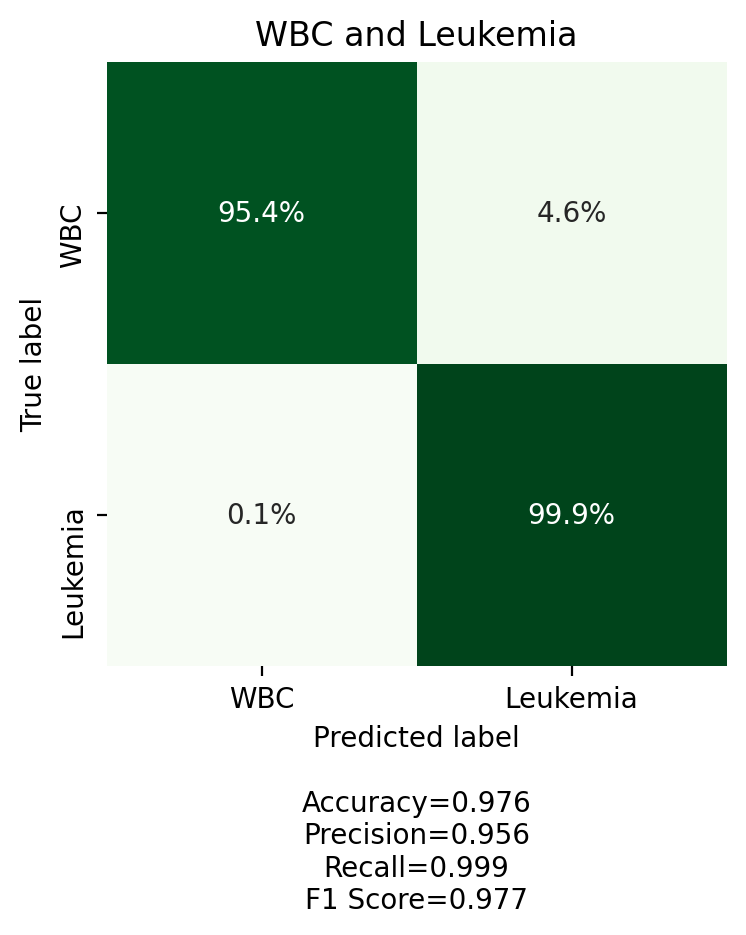

In [30]:
confusionMat = np.asarray(cm)
sumconfusion = np.sum(confusionMat,axis = 1).T
summat = np.tile(sumconfusion,(2,1)).T
percentconfusion_val = np.divide(confusionMat,summat)

categories = ['WBC','Leukemia']
make_confusion_matrix(percentconfusion_val, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Greens',my_dpi=200,title = 'WBC and Leukemia',
                      saved=False, save_name='nets/ckpt_CAE_3D_bn_002/Fig_save/Unsupervised Learning - wbc+leu.jpg')

In [33]:
from datetime import datetime

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%H_%M_%b%d%Y")

fname21 = "reports/leu/X_2d_leu+wbc_val_bn2_"+timestampStr+".csv"
np.savetxt(fname21, X_2d_mix , delimiter=",")
fname22 = "reports/leu/Labellist_leu+wbc_val_bn2_"+timestampStr+".csv"
np.savetxt(fname22, labellist_mix , delimiter=",")
fname23 = "reports/leu/Latent_out_leu+wbc_val_bn2_"+timestampStr+".csv"
np.savetxt(fname23, latent_out_mix , delimiter=",")

fname24 = "reports/leu/Clustering_idx_leu+wbc_val_bn2_"+timestampStr+".csv"
np.savetxt(fname24, c_idx_mbk_mix , delimiter=",")
fname25 = "reports/leu/ClusteringMatchedidx_leu+wbc_val_bn2_"+timestampStr+".csv"
np.savetxt(fname25, idx_match_mix , delimiter=",")
fname26 = "reports/leu/Index_leu+wbc_val_bn2_"+timestampStr+".csv"
np.savetxt(fname26, index_mix , delimiter=",")

fname27 = "reports/leu/val_path_bn002_"+timestampStr+".csv"
np.savetxt(fname27, testpath, fmt="%s", delimiter=",")